# What am I Investigating?
Tennis is a racquet sport that can be played individually against a single opponent (singles) or between two teams of two players each (doubles). Players use a strung racquet to strike a hollow rubber ball, covered with felt, over a net and into the opponent's court. The objective of the game is to play the ball in such a way that the opponent cannot play a valid return. The player who is unable to return the ball will not gain a point, while the opposite player will.  
Tennis is played on different surfaces, including grass, clay, hard courts, and even indoor carpet. Each surface affects the ball's speed and bounce differently, leading to varied styles of play.  
*I'm intrested to find out if there's a relationship between the surface the match was played on and its duration*.

# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_columns', 50)

# Loading Data

In [2]:
folder_path = '/content/drive/MyDrive/Tennis_Analysis/full_matches_data'

# List all files in the directory with a .csv extension
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]

# Use a list comprehension to read each file into a dataframe and then concatenate them all
combined_df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in all_files], ignore_index=True)

In [3]:
combined_df.sample(10)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,...,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
77065,2013-422,Cincinnati Masters,Hard,56,M,20130811,6,104545,NaN,NaN,John Isner,R,206.0,USA,28.2,104252,NaN,NaN,Florian Mayer,R,190.0,GER,...,17.0,0.0,51.0,35.0,29.0,12.0,10.0,0.0,0.0,3.0,5.0,57.0,25.0,18.0,16.0,9.0,3.0,5.0,22.0,1585.0,47.0,940.0
83426,2015-5014,Shanghai Masters,Hard,56,M,20151011,48,104542,16.0,NaN,Jo-Wilfried Tsonga,R,188.0,FRA,30.4,105077,NaN,Q,Albert Ramos,L,188.0,ESP,...,15.0,1.0,94.0,60.0,50.0,21.0,17.0,1.0,2.0,4.0,3.0,127.0,83.0,55.0,22.0,17.0,12.0,15.0,15.0,1990.0,70.0,703.0
44343,2003-407,Rotterdam,Hard,32,A,20030217,2,102035,NaN,NaN,Jonas Bjorkman,R,183.0,SWE,30.9,103193,NaN,Q,Peter Wessels,R,196.0,NED,...,5.0,3.0,45.0,26.0,21.0,10.0,8.0,1.0,2.0,4.0,4.0,57.0,27.0,16.0,10.0,8.0,9.0,14.0,69.0,595.0,445.0,49.0
83696,2016-0891,Chennai,Hard,32,A,20160104,297,104527,1.0,NaN,Stan Wawrinka,R,183.0,SUI,30.7,104198,5.0,NaN,Guillermo Garcia Lopez,R,188.0,ESP,...,14.0,0.0,51.0,38.0,31.0,8.0,10.0,0.0,1.0,5.0,2.0,74.0,44.0,26.0,16.0,10.0,6.0,9.0,4.0,6865.0,27.0,1430.0
5025,1992-434,Seoul,Hard,32,A,19920420,20,101412,5.0,NaN,Shuzo Matsuoka,R,185.0,JPN,24.4,101776,NaN,NaN,Sandon Stolle,R,193.0,AUS,...,1.0,0.0,55.0,32.0,26.0,16.0,10.0,0.0,0.0,4.0,4.0,66.0,48.0,33.0,9.0,10.0,5.0,7.0,90.0,394.0,135.0,270.0
38070,2001-416,Rome Masters,Clay,64,M,20010507,6,102287,NaN,Q,Albert Portas,R,188.0,ESP,27.4,102765,NaN,NaN,Nicolas Escude,R,185.0,FRA,...,0.0,3.0,78.0,44.0,34.0,15.0,11.0,2.0,4.0,10.0,5.0,108.0,61.0,37.0,24.0,11.0,10.0,13.0,45.0,820.0,34.0,925.0
65498,2009-D009,Davis Cup WG QF: CZE vs ARG,Carpet,4,D,20090710,2,105223,NaN,NaN,Juan Martin del Potro,R,198.0,ARG,20.7,104371,NaN,NaN,Ivo Minar,R,183.0,CZE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5705.0,64.0,906.0
98079,2021-5053,Belgrade,Clay,32,A,20210419,292,200175,8.0,NaN,Miomir Kecmanovic,R,183.0,SRB,21.6,126239,NaN,Q,Arthur Rinderknech,R,196.0,FRA,...,1.0,3.0,75.0,49.0,31.0,18.0,14.0,2.0,6.0,10.0,0.0,70.0,48.0,29.0,9.0,13.0,2.0,7.0,47.0,1364.0,129.0,593.0
55180,2006-500,Halle,Grass,32,A,20060612,30,104607,5.0,NaN,Tomas Berdych,R,196.0,CZE,20.7,104019,8.0,NaN,Kristof Vliegen,R,193.0,BEL,...,5.0,3.0,55.0,32.0,29.0,10.0,9.0,5.0,5.0,4.0,3.0,46.0,33.0,23.0,2.0,8.0,0.0,3.0,15.0,1505.0,42.0,822.0
76205,2013-416,Rome Masters,Clay,56,M,20130512,18,104719,NaN,NaN,Marcel Granollers,R,190.0,ESP,27.0,103786,NaN,NaN,Nikolay Davydenko,R,178.0,RUS,...,1.0,0.0,54.0,36.0,30.0,9.0,10.0,0.0,1.0,0.0,4.0,62.0,45.0,28.0,7.0,9.0,4.0,7.0,37.0,1055.0,44.0,915.0


# Understanding the Big Picture

Getting the number of rows and columns in the dataset (pre-cleaning):

In [4]:
number_of_rows = combined_df.shape[0]
number_of_columns = combined_df.shape[1]

print(f"The dataset has {number_of_rows} rows and {number_of_columns} columns.")

The dataset has 104682 rows and 49 columns.


Getting information about the data (I mainly use it to see which columns has high number of NA's):

In [5]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104682 entries, 0 to 104681
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          104682 non-null  object 
 1   tourney_name        104682 non-null  object 
 2   surface             104682 non-null  object 
 3   draw_size           104682 non-null  int64  
 4   tourney_level       104682 non-null  object 
 5   tourney_date        104682 non-null  int64  
 6   match_num           104682 non-null  int64  
 7   winner_id           104682 non-null  int64  
 8   winner_seed         42400 non-null   float64
 9   winner_entry        12809 non-null   object 
 10  winner_name         104682 non-null  object 
 11  winner_hand         104673 non-null  object 
 12  winner_ht           102228 non-null  float64
 13  winner_ioc          104682 non-null  object 
 14  winner_age          104677 non-null  float64
 15  loser_id            104682 non-nul

Checking if there are any duplicate rows:

In [ ]:
number_of_duplicated_rows = combined_df.duplicated().sum()
print(f"There are {number_of_duplicated_rows} duplicated rows in the dataset.")

There are 0 duplicated rows in the dataset.


# Data Cleaning

Deleting matches that we don't know their statistics:

In [7]:
# Creating a list of columns names that has the statistics
match_data_columns_names = ["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced", "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced"]

# Dropping all the rows based on the subset of columns in the list above
combined_df.dropna(subset=match_data_columns_names, inplace=True)

# Checking if it worked
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94475 entries, 0 to 104585
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          94475 non-null  object 
 1   tourney_name        94475 non-null  object 
 2   surface             94475 non-null  object 
 3   draw_size           94475 non-null  int64  
 4   tourney_level       94475 non-null  object 
 5   tourney_date        94475 non-null  int64  
 6   match_num           94475 non-null  int64  
 7   winner_id           94475 non-null  int64  
 8   winner_seed         41696 non-null  float64
 9   winner_entry        12639 non-null  object 
 10  winner_name         94475 non-null  object 
 11  winner_hand         94470 non-null  object 
 12  winner_ht           94140 non-null  float64
 13  winner_ioc          94475 non-null  object 
 14  winner_age          94475 non-null  float64
 15  loser_id            94475 non-null  int64  
 16  los

Deleting unnecessary columns:

In [9]:
names_of_columns_to_drop = ["winner_seed", "winner_entry", "loser_seed", "loser_entry"]

combined_df.drop(columns=["winner_seed", "winner_entry", "loser_seed", "loser_entry", "match_num"], inplace=True)

combined_df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'winner_id', 'winner_name', 'winner_hand', 'winner_ht',
       'winner_ioc', 'winner_age', 'loser_id', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

Changing the format of the dates in the tourney_date column, from `YYYYMMDD` format to `Y M D` format.

In [10]:
combined_df['tourney_date'] = pd.to_datetime(combined_df['tourney_date'], format='%Y%m%d')
combined_df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1991-339,Adelaide,Hard,32,A,1990-12-31,101723,Magnus Larsson,R,193.0,SWE,20.7,101414,Boris Becker,R,190.0,GER,23.1,6-4 3-6 7-6(2),3,R32,130.0,6.0,2.0,96.0,55.0,39.0,25.0,15.0,2.0,4.0,8.0,3.0,95.0,62.0,44.0,23.0,16.0,6.0,8.0,56.0,NaN,2.0,NaN
1,1991-339,Adelaide,Hard,32,A,1990-12-31,100946,Slobodan Zivojinovic,R,198.0,YUG,27.4,101256,Mark Kratzmann,L,178.0,AUS,24.6,6-3 3-6 7-6(6),3,R32,119.0,19.0,4.0,101.0,56.0,45.0,25.0,15.0,9.0,10.0,8.0,2.0,84.0,41.0,35.0,27.0,15.0,1.0,2.0,304.0,NaN,75.0,NaN
2,1991-339,Adelaide,Hard,32,A,1990-12-31,101234,Patrik Kuhnen,R,190.0,GER,24.8,101421,Veli Paloheimo,R,183.0,FIN,23.0,6-0 6-4,3,R32,71.0,6.0,1.0,54.0,31.0,24.0,13.0,8.0,1.0,1.0,2.0,2.0,60.0,37.0,22.0,6.0,8.0,4.0,8.0,82.0,NaN,69.0,NaN
3,1991-339,Adelaide,Hard,32,A,1990-12-31,101889,Todd Woodbridge,R,178.0,AUS,19.7,101703,Guillaume Raoux,R,180.0,FRA,20.8,7-6(2) 6-1,3,R32,85.0,2.0,0.0,60.0,40.0,30.0,14.0,9.0,3.0,3.0,3.0,3.0,74.0,45.0,30.0,11.0,10.0,5.0,8.0,50.0,NaN,84.0,NaN
4,1991-339,Adelaide,Hard,32,A,1990-12-31,101274,Udo Riglewski,R,185.0,GER,24.4,101843,Sergi Bruguera,R,188.0,ESP,19.9,7-5 6-3,3,R32,90.0,4.0,2.0,72.0,40.0,33.0,14.0,10.0,7.0,8.0,2.0,2.0,77.0,41.0,28.0,15.0,11.0,4.0,8.0,88.0,NaN,28.0,NaN


Creating new columns:

In [11]:
# Creating a variable called "total_points" - the total points played in the match.
combined_df["total_points"] = combined_df["w_svpt"]+combined_df["l_svpt"]

combined_df.sample(7)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,total_points
53311,2006-308,Munich,Clay,32,A,2006-05-01,103694,Olivier Rochus,R,168.0,BEL,25.2,103395,Julio Silva,R,173.0,BRA,26.8,6-2 6-0,3,R32,59.0,0.0,0.0,35.0,25.0,19.0,7.0,7.0,1.0,2.0,3.0,1.0,49.0,31.0,14.0,4.0,7.0,4.0,10.0,30.0,980.0,203.0,188.0,84.0
20128,1996-360,Casablanca,Clay,32,A,1996-03-25,102522,Fabio Maggi,R,175.0,ITA,21.1,102339,Kris Goossens,R,180.0,BEL,22.0,3-6 6-3 6-4,3,R32,145.0,0.0,0.0,90.0,56.0,32.0,22.0,14.0,5.0,9.0,1.0,3.0,108.0,74.0,49.0,11.0,14.0,9.0,14.0,255.0,NaN,93.0,NaN,198.0
42094,2002-499,Delray Beach,Hard,32,A,2002-03-04,102694,Lars Burgsmuller,R,183.0,GER,26.2,103397,Alexandre Simoni,R,188.0,BRA,22.6,6-2 4-6 6-2,3,R32,105.0,15.0,2.0,72.0,44.0,33.0,19.0,13.0,3.0,4.0,12.0,5.0,101.0,64.0,42.0,16.0,13.0,7.0,11.0,79.0,492.0,129.0,311.0,173.0
95681,2020-0499,Delray Beach,Hard,32,A,2020-02-17,206909,Brandon Nakashima,R,185.0,USA,18.5,106210,Jiri Vesely,L,198.0,CZE,26.6,7-6(4) 6-1,3,R32,81.0,5.0,2.0,58.0,33.0,24.0,17.0,9.0,1.0,1.0,12.0,4.0,61.0,39.0,27.0,7.0,10.0,1.0,4.0,294.0,139.0,74.0,760.0,119.0
44742,2003-421,Canada Masters,Hard,64,M,2003-08-04,102344,Karol Kucera,R,188.0,SVK,29.4,103507,Juan Carlos Ferrero,R,183.0,ESP,23.4,6-3 7-5,3,R16,88.0,8.0,2.0,60.0,32.0,23.0,13.0,11.0,2.0,6.0,0.0,2.0,60.0,38.0,19.0,10.0,10.0,3.0,9.0,41.0,868.0,2.0,3815.0,120.0
64521,2009-5014,Shanghai Masters,Hard,56,M,2009-10-11,104745,Rafael Nadal,L,185.0,ESP,23.3,103990,Tommy Robredo,R,180.0,ESP,27.4,6-1 6-4,3,R16,93.0,0.0,2.0,57.0,42.0,29.0,9.0,9.0,1.0,2.0,2.0,2.0,57.0,33.0,20.0,9.0,8.0,6.0,10.0,2.0,8945.0,15.0,2090.0,114.0
76630,2013-540,Wimbledon,Grass,128,G,2013-06-24,103852,Feliciano Lopez,L,188.0,ESP,31.7,103908,Paul Henri Mathieu,R,185.0,FRA,31.4,6-3 5-1 RET,5,R64,56.0,13.0,1.0,33.0,21.0,19.0,9.0,7.0,0.0,0.0,3.0,4.0,47.0,21.0,13.0,12.0,8.0,2.0,6.0,32.0,1245.0,82.0,616.0,80.0


# Univariate Analysis

## Categorical Variables

Counting the number of games played on each surface type (and plotting it):

In [ ]:
combined_df.surface.value_counts()

Hard      47729
Clay      31085
Grass      9783
Carpet     5878
Name: surface, dtype: int64

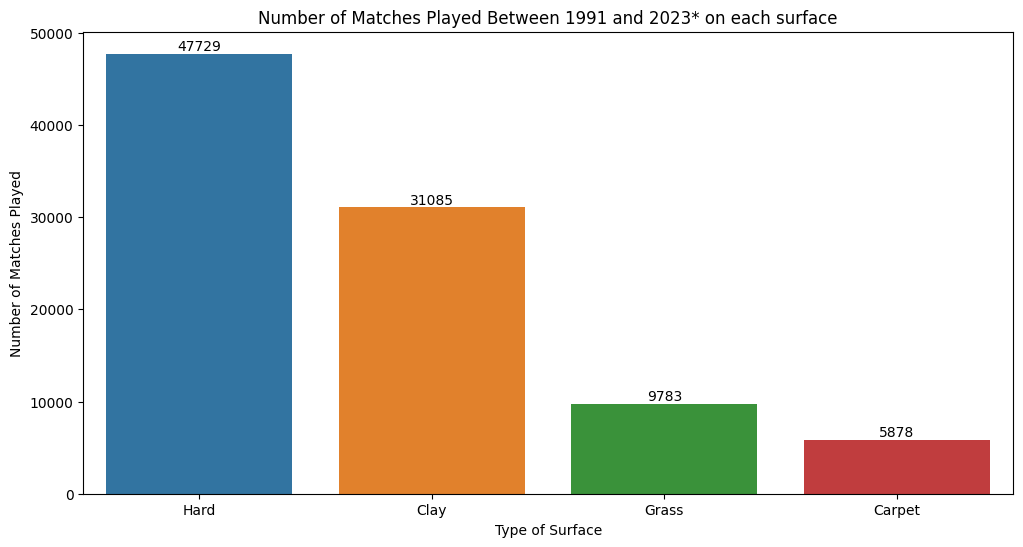

In [ ]:
plt.figure(figsize=(12,6))
surfaces_countplot = sns.countplot(data=combined_df, x="surface", order=combined_df.surface.value_counts().index)
surfaces_countplot.bar_label(surfaces_countplot.containers[0], label_type='edge')
surfaces_countplot.set_xlabel("Type of Surface")
surfaces_countplot.set_ylabel("Number of Matches Played")
surfaces_countplot.set_title("Number of Matches Played Between 1991 and 2023* on each surface")
plt.show()

Counting the number of times a best of 3 sets and a best of 5 sets were played (and plotting it):

In [ ]:
combined_df.best_of.value_counts()

3    77549
5    16926
Name: best_of, dtype: int64

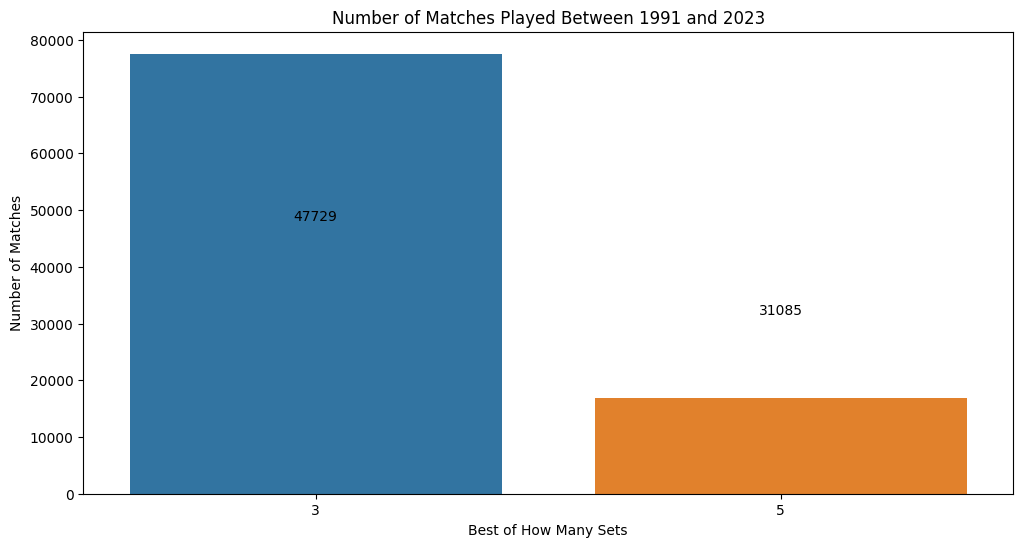

In [ ]:
plt.figure(figsize=(12,6))
best_of_countplot = sns.countplot(data=combined_df, x="best_of", order=combined_df.best_of.value_counts().index)
best_of_countplot.bar_label(surfaces_countplot.containers[0], label_type='edge')
best_of_countplot.set_xlabel("Best of How Many Sets")
best_of_countplot.set_ylabel("Number of Matches")
best_of_countplot.set_title("Number of Matches Played Between 1991 and 2023")
plt.show()

In [ ]:
combined_df.winner_hand.value_counts()

R    80993
L    13352
U      117
A        8
Name: winner_hand, dtype: int64

In [ ]:
combined_df.loser_hand.value_counts()

R    80149
L    13969
U      306
A       27
Name: loser_hand, dtype: int64

## Numerical Variables

Analyzing the total_points variable:

In [ ]:
combined_df.total_points.describe()

count    94475.000000
mean       159.096047
std         57.432572
min          1.000000
25%        116.000000
50%        148.000000
75%        191.000000
max        980.000000
Name: total_points, dtype: float64

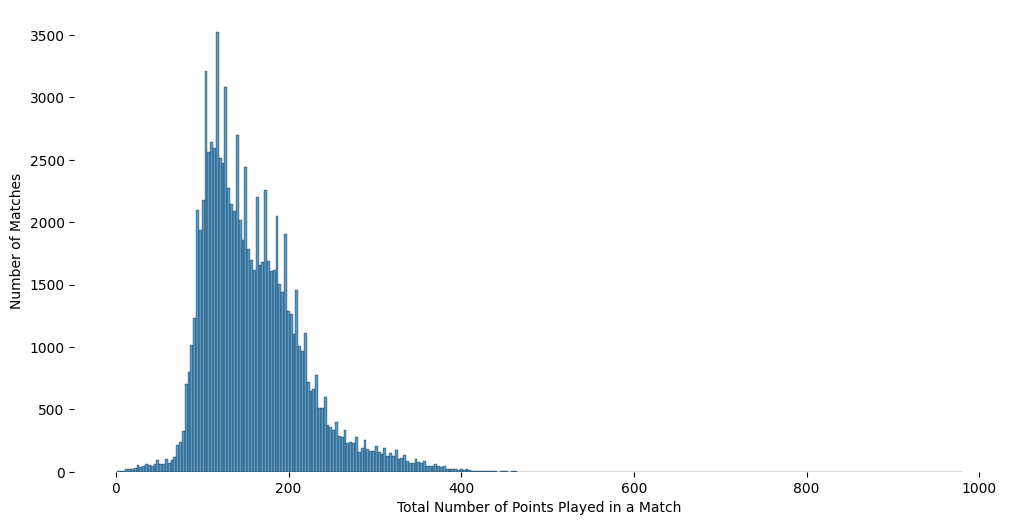

In [ ]:
plt.figure(figsize=(12, 6))
total_point_histogram = sns.histplot(data=combined_df, x="total_points")
sns.despine(left=True, bottom=True)
total_point_histogram.set_xlabel("Total Number of Points Played in a Match")
total_point_histogram.set_ylabel("Number of Matches")
plt.show()